# Imports

In [1]:
import gensim
from gensim import corpora
from pprint import pprint
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import numpy as np
import sklearn
import pandas as pd
import umap
from pymongo import MongoClient
from sklearn.neighbors import NearestNeighbors
import tqdm
import pickle

/home/vagrant/venv/lib/python3.6/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


# Read Data 

In [2]:
type(spark)

pyspark.sql.session.SparkSession

In [3]:
df = spark.read.parquet('/mtgp/artifacts/dataset/M20_cards.parquet')

In [4]:
as_dict = df.rdd.map(lambda row: row.asDict())

In [5]:
cards = as_dict.collect()

# Tokenize

In [6]:
field_text = "filteredText"

data_list = [{'number': card['number'], 'text': card[field_text], 'name': card['name']} for card in cards if field_text in card if card[field_text] is not None]
card_names = list(map(lambda card: card['name'], data_list))
data = list(map(lambda card: card['text'], data_list))

In [7]:
tagged_data = [
    TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)])
    for i, _d in enumerate(data) if _d is not None
]

# Train model

In [8]:
max_epochs = 100
vec_size = 50
alpha = 0.025

In [9]:
model = Doc2Vec(vector_size=vec_size, alpha=alpha, min_alpha=0.00025, min_count=1, dm=1)
model.build_vocab(tagged_data)

In [10]:
for epoch in tqdm.tqdm(range(max_epochs)):
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


In [11]:
# model.save("d2v.model")

In [12]:
X = list()

for i in tqdm.tqdm(range(len(model.docvecs))):
    X.append(model.docvecs[i])
    
docvecs = np.array(X)

100%|██████████| 312/312 [00:00<00:00, 201357.57it/s]


# Project and embed data

In [13]:
rng = np.random.RandomState(0)

In [14]:
pca = sklearn.decomposition.PCA(random_state=rng)
X_docvecs = pca.fit_transform(docvecs)

In [15]:
mdl_umap = umap.UMAP(n_neighbors=5, metric='euclidean', random_state=rng, transform_seed=rng)
embedded_docvecs = mdl_umap.fit_transform(docvecs)

In [16]:
# with open("../mdl_umap.pickle","wb") as fp:
#     pickle.dump(mdl_umap, fp)
# fp.close()

# Find similar cards (up to 20) and cache the results

In [17]:
similarity_results = list()

for card, embedded_vector in zip(cards, embedded_docvecs):
    knn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    knn.fit(embedded_docvecs)
    
    distances, neighs_ids = knn.kneighbors(np.reshape(embedded_vector,[1, 2]), 20, return_distance=True)
    
    similarity_results.append({'number': card['number'], 'similar': neighs_ids[0].tolist()})

# Save feature vectors 

In [18]:
# client = MongoClient("localhost")
# db = client['mtggg']

In [19]:
feats = [{'number': card['number'], 'docvect': feature_vector.tolist(), 'embedded_vect': embedded_vector.tolist()} 
             for card, feature_vector, embedded_vector in zip(cards, docvecs, embedded_docvecs)
]

In [20]:
# result = db.ml.feats.v1.insert_many(feats)
# result.acknowledged

In [21]:
# result = db.ml.similar.v1.insert_many(similarity_results)
# result.acknowledged

# Plot scatter

In [22]:
mdl_umap = umap.UMAP(n_neighbors=5, metric='euclidean', random_state=rng, transform_seed=rng)
embedded_docvecs = mdl_umap.fit_transform(docvecs)

In [23]:
df = pd.DataFrame(np.hstack([embedded_docvecs, np.reshape(data, [312, 1]), np.reshape(card_names, [312, 1])]), columns=['x', 'y', 'text', 'name'])

In [25]:
# as long it's attacking

In [26]:
# as long it's your turn

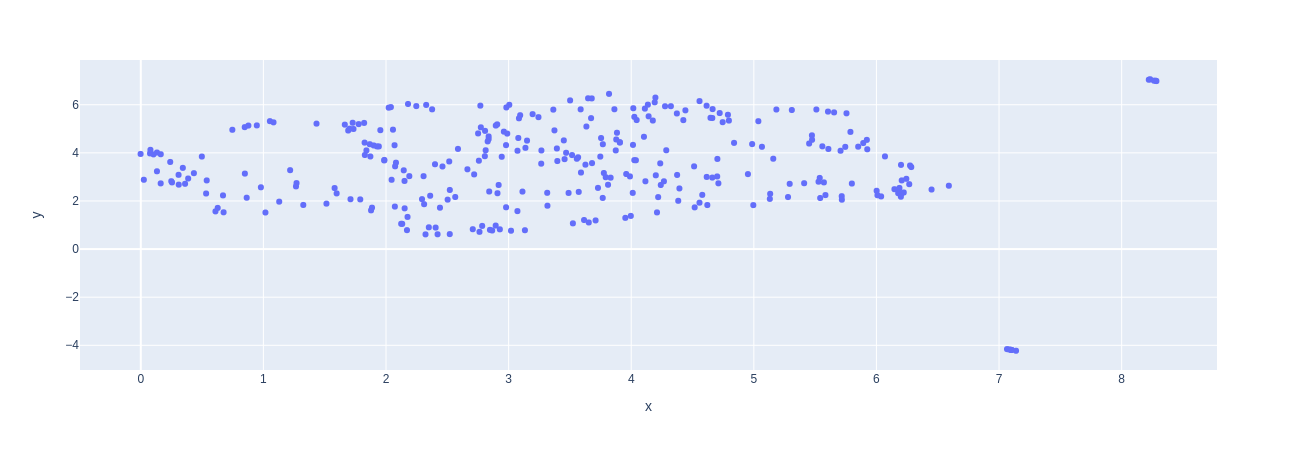

In [24]:
import plotly
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)

fig = px.scatter(data_frame=df, x='x', y='y', hover_data=['name', 'text'])
fig.show()